# <h2><center> Final project</center></h2>
<h2><center>Lê Vũ Lợi - Trần Thị Uyên </center></h2>

## 1. Tổng quan:

Nowadays, the use of online services to watch movies has become familiar for people. The development of movies platforms makes it easier for users to access movies. However, too many choices also make it difficult for users to find the right movie. A Recommendation system could solve this problem. 

**Dataset**:
    
    - MovieLens 20M : Contains 20000263 ratings and 465564 tag applications across 27278 movies. These data were created by 138493 users between January 09, 1995 and March 31, 2015. 
    
    - File data used: movies.cvs, ratings.cvs, tags.csv, links.csv
    
    
**Procedure**

    - Store data in hadoop File system

    - Utilized PySpark to load movielens data and used SQL to query and analyze data 
    
    - Get more movie detail through ImdbPy
    
    - Applied Collaborative Filtering and Matrix Factorization methods to construct a recommendation system with PySpark
   

# 1. Read data and example

In [1]:
# import pyspark
from pyspark.sql.functions import col,isnan,when,count
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [2]:
# # url = "http://52.148.66.196:9870/explorer.html?fbclid=IwAR1OyYXTkaoIElLoH-Ftx03q0z3TuCGlDyzDzmxBreqbboqqqdFC4-L4Wrk#/user/levuloi/movielens"
# df_movies = df_load = spark.read.csv(url+'/movies.csv',header=True,)
# df_movies.printSchema()
# df_movies.show(5)

In [2]:
movies_df = spark.read.csv('ml-20m/movies.csv',header=True,)
movies_df.printSchema()
movies_df.show(5)

root
 |-- movieId: string (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [3]:
ratings_df = spark.read.csv('ml-20m/ratings.csv',header=True,)
ratings_df.printSchema()
ratings_df.show(5)

root
 |-- userId: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- timestamp: string (nullable = true)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|      2|   3.5|1112486027|
|     1|     29|   3.5|1112484676|
|     1|     32|   3.5|1112484819|
|     1|     47|   3.5|1112484727|
|     1|     50|   3.5|1112484580|
+------+-------+------+----------+
only showing top 5 rows



In [4]:
links_df = spark.read.csv('ml-20m/links.csv',header=True,)
links_df.printSchema()
links_df.show(5)

root
 |-- movieId: string (nullable = true)
 |-- imdbId: string (nullable = true)
 |-- tmdbId: string (nullable = true)

+-------+-------+------+
|movieId| imdbId|tmdbId|
+-------+-------+------+
|      1|0114709|   862|
|      2|0113497|  8844|
|      3|0113228| 15602|
|      4|0114885| 31357|
|      5|0113041| 11862|
+-------+-------+------+
only showing top 5 rows



# 2. Rarting Distribution

### Check if have null data  

In [5]:
col_df = ["userId", "movieId", "rating", "timestamp"]
ratings_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in col_df]).show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     0|      0|     0|        0|
+------+-------+------+---------+



In [6]:
count_rate_df = ratings_df.groupBy("rating").count()
count_rate_df.show(5)

+------+-------+
|rating|  count|
+------+-------+
|   1.0| 680732|
|   4.5|1534824|
|   2.5| 883398|
|   3.5|2200156|
|   5.0|2898660|
+------+-------+
only showing top 5 rows



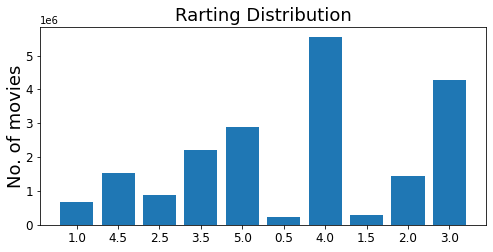

In [7]:
numRate = count_rate_df.count()

import matplotlib.pyplot as plt
fig = plt.figure(1, figsize=(8,8))
ax2 = fig.add_subplot(2,1,2)
y_axis = [count_rate_df.collect()[i][1] for i in range(numRate)]
x_axis = [i for i in range(numRate)]
x_label = [count_rate_df.collect()[i][0] for i in range(numRate)]
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xticks(x_axis, x_label)
plt.ylabel("No. of movies", fontsize = 18, labelpad = 0)
ax2.bar(x_axis, y_axis, align = 'center')
plt.title("Rarting Distribution",fontsize = 18)
plt.show()

In [8]:
count_time_df = ratings_df.groupBy("timestamp").count()
count_time_df.show(5)

+----------+-----+
| timestamp|count|
+----------+-----+
|1112485843|    1|
| 944917666|    2|
|1011205286|    2|
|1011206375|    2|
|1251170857|    1|
+----------+-----+
only showing top 5 rows



In [9]:
numTime = count_time_df.count()
print(numTime)
x_value = [count_time_df.collect()[i][0] for i in range(numTime)]
y_value = [count_time_df.collect()[i][1] for i in range(numTime)]

15351121


Py4JJavaError: An error occurred while calling o105.collectToPython.
: java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.sql.execution.SparkPlan$$anon$1.next(SparkPlan.scala:373)
	at org.apache.spark.sql.execution.SparkPlan$$anon$1.next(SparkPlan.scala:369)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at org.apache.spark.sql.execution.SparkPlan$$anon$1.foreach(SparkPlan.scala:369)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeCollect$1(SparkPlan.scala:391)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeCollect$1$adapted(SparkPlan.scala:390)
	at org.apache.spark.sql.execution.SparkPlan$$Lambda$2878/0x00000001011f6840.apply(Unknown Source)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach(ArrayOps.scala:198)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:390)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:3519)
	at org.apache.spark.sql.Dataset$$Lambda$3010/0x0000000101268040.apply(Unknown Source)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3687)
	at org.apache.spark.sql.Dataset$$Lambda$1514/0x0000000100c3cc40.apply(Unknown Source)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$$$Lambda$1522/0x0000000100c49040.apply(Unknown Source)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.execution.SQLExecution$$$Lambda$1515/0x0000000100c3d840.apply(Unknown Source)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3685)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3516)
	at jdk.internal.reflect.GeneratedMethodAccessor66.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)


In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x_value, y_value, "g-o")
ax.grid(None)
ax.set_ylim(0,)
plt.show()

# 3.Top 10 most viewed movies

### GroupBy using “movieId" count the number of users who watched a particular movie
Sorting in decreasing order
Show movies with name and cover picture
- Join movies and views
- Join links and views

In [16]:
views_df = ratings_df.groupBy("movieId").count()
movies_df.join(views_df, views_df.movieId == movies_df.movieId ,"full").sort(col("count").desc()).show(5)

+-------+--------------------+--------------------+-------+-----+
|movieId|               title|              genres|movieId|count|
+-------+--------------------+--------------------+-------+-----+
|    296| Pulp Fiction (1994)|Comedy|Crime|Dram...|    296|67310|
|    356| Forrest Gump (1994)|Comedy|Drama|Roma...|    356|66172|
|    318|Shawshank Redempt...|         Crime|Drama|    318|63366|
|    593|Silence of the La...|Crime|Horror|Thri...|    593|63299|
|    480|Jurassic Park (1993)|Action|Adventure|...|    480|59715|
+-------+--------------------+--------------------+-------+-----+
only showing top 5 rows



### Get imdbId of top 5 movie

In [21]:
views_links_df = links_df.join(views_df,links_df.movieId == views_df.movieId,"full").sort(col("count").desc())
views_links = [ row.imdbId for row in views_links_df.head(5)]
print(views_links)

['0110912', '0109830', '0111161', '0102926', '0107290']


### Get cover imagine of movies

In [26]:
import imdb
from IPython.display import  display, Image
from IPython.core.display import HTML 
from io import BytesIO

ia = imdb.IMDb()
list_img = []
for code in views_links:
    # getting information
    series = ia.get_movie(code)
    cover = series.data['cover url']
    list_img.append(Image(url= cover))

display(list_img[0],list_img[1], list_img[2], list_img[3], list_img[4])

### 4. Number of movies are there in each genres

### Count the Number of movies are there in each genres

In [27]:
from pyspark.sql import functions as F
import pandas as pd

df_movies_genres = movies_df.select('movieId',F.explode(F.split(movies_df.genres,'[|]')).alias('genre'))
df = df_movies_genres.groupBy("genre").count()
df.show(5)

+---------+-----+
|    genre|count|
+---------+-----+
|    Crime| 2939|
|  Romance| 4127|
| Thriller| 4178|
|Adventure| 2329|
|    Drama|13344|
+---------+-----+
only showing top 5 rows



df(type): pandas dataframe

### Data Visualization

In [28]:
import numpy as np #provides numerical arrays and functions to manipulate the arrays efficiently
import random
import matplotlib.pyplot as plt # data visualization library
from wordcloud import WordCloud, STOPWORDS #used to generate world clou

In [29]:
numGenre = df.count()
print(numGenre)
words = dict()
for i in range(numGenre):
    words[df.collect()[i][0]] = df.collect()[i][1]
print(words)

20
{'Crime': 2939, 'Romance': 4127, 'Thriller': 4178, 'Adventure': 2329, 'Drama': 13344, 'War': 1194, 'Documentary': 2471, 'Fantasy': 1412, 'Mystery': 1514, 'Musical': 1036, 'Animation': 1027, 'Film-Noir': 330, '(no genres listed)': 246, 'IMAX': 196, 'Horror': 2611, 'Western': 676, 'Comedy': 8374, 'Children': 1139, 'Action': 3520, 'Sci-Fi': 1743}


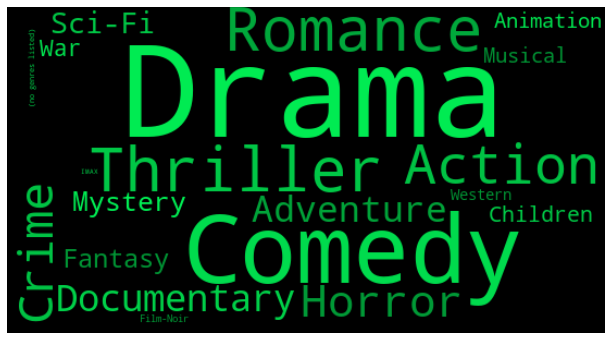

In [30]:
# Function that control the color of the words
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)


#Finally, the result is shown as a wordcloud:
tone = 100 # define the color of the words
f, ax = plt.subplots(figsize=(14, 6))
wordcloud = WordCloud(width=550,height=300, background_color='black', 
                      max_words=1628,relative_scaling=0.7,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

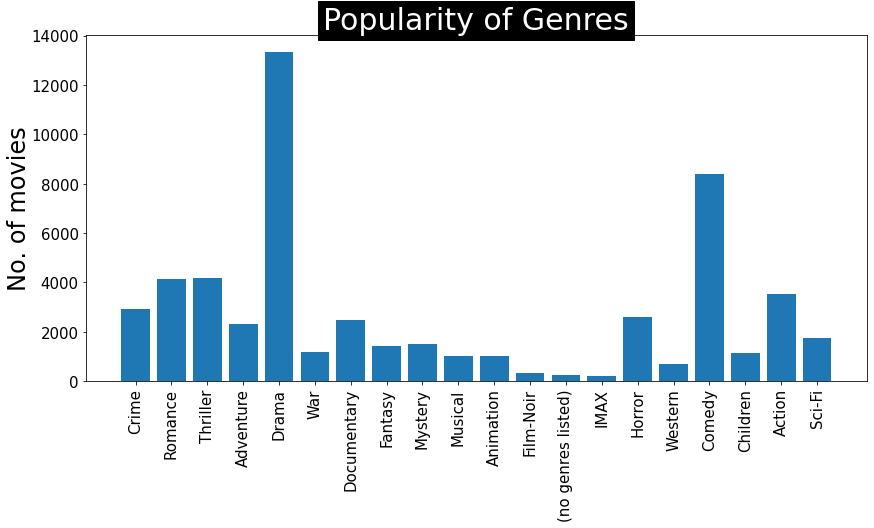

In [31]:
# lets display the same result in the histogram
fig = plt.figure(1, figsize=(14,14))
ax2 = fig.add_subplot(2,1,2)
y_axis = [df.collect()[i][1] for i in range(numGenre)]
x_axis = [i for i in range(numGenre)]
x_label = [df.collect()[i][0] for i in range(numGenre)]
plt.xticks(rotation=90, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("No. of movies", fontsize = 24, labelpad = 0)
ax2.bar(x_axis, y_axis, align = 'center')
plt.title("Popularity of Genres",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 30)
plt.show()

In [ ]:
ALS 